You will be using transfer learning on a large, known dataset called [MSCOCO](https://cocodataset.org/#download). Specifically, you will perform the task of "reference resolution" that identifies objects in images using referring expressions. 



### Download dataset

The mscoco dataset is pretty big (12 GB). We won't be using all of the data, but it makes matters easier to have everything together in one place. To help you download the data, you can run the following script (might need to open the script and follow step by step on windows). You will only need to run this once!

There is an [https://github.com/lichengunc/refer/blob/master/refer.py](API) to help you access and use the dataset. The main API is in the refer.py file. Run the following cell to import it, along with some other useful libraries (you may need to run pip to install them):

In [27]:
from refer import REFER
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import os
from PIL import Image as PImage # pillow

### Load the MSOCO dataset with referring expressions, show some stats. 

Notice that the datasets are already split into train, val, and test sets. This is to make it so everyone who uses the dataset can directly compare their results with each other. 

You will train using the `train` set. You will develop your model with the `val` set. After you think you are done, you will perform a final evaluation on the `test` dataset. 

In [28]:
data_root = 'coco'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco' 
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

loading dataset refcoco into memory...
creating index...
index created.
DONE (t=10.99s)


In [29]:
# print stats about the given dataset
print ('dataset [%s_%s] contains: ' % (dataset, splitBy))
ref_ids = refer.getRefIds()
image_ids = refer.getImgIds()
print ('%s expressions for %s refs in %s images.' % (len(refer.Sents), len(ref_ids), len(image_ids)))

print ('\nAmong them:')
if dataset == 'refclef':
    if splitBy == 'unc':
        splits = ['train', 'val', 'testA', 'testB', 'testC']
    else:
        splits = ['train', 'val', 'test']
elif dataset == 'refcoco':
    splits = ['train', 'val', 'test']
elif dataset == 'refcoco+':
    splits = ['train', 'val', 'test']
elif dataset == 'refcocog':
    splits = ['train', 'val']  # we don't have test split for refcocog right now.
    
for split in splits:
    ref_ids = refer.getRefIds(split=split)
    print ('%s refs are in split [%s].' % (len(ref_ids), split))

dataset [refcoco_unc] contains: 
142210 expressions for 50000 refs in 19994 images.

Among them:
42404 refs are in split [train].
3811 refs are in split [val].
3785 refs are in split [test].


### Example

- run the cells
- each sentence (i.e., referring expression) has an id with images and sub-images associated with it within a dictionary
- there is one object as a sub-image box denoted by the green box outline
- there are three referring expressions for that object

In [30]:
ref_ids = refer.getRefIds()
print(len(ref_ids))
ref_id = 35254 # pick a random ref_id
ref = refer.Refs[ref_id]

ref # a dictionary with all of the needed info for a referring expression+image

50000


{'sent_ids': [100272, 100273, 100274],
 'file_name': 'COCO_train2014_000000173056_1.jpg',
 'ann_id': 275551,
 'ref_id': 35254,
 'image_id': 173056,
 'split': 'train',
 'sentences': [{'tokens': ['white', 'brown', 'sheep', 'right'],
   'raw': 'white brown sheep right',
   'sent_id': 100272,
   'sent': 'white brown sheep right'},
  {'tokens': ['black', 'sheep', 'on', 'right'],
   'raw': 'black sheep on right',
   'sent_id': 100273,
   'sent': 'black sheep on right'},
  {'tokens': ['sheep', 'on', 'the', 'right'],
   'raw': 'sheep on the right',
   'sent_id': 100274,
   'sent': 'sheep on the right'}],
 'category_id': 20}

ref_id [35254] (ann_id [275551])
1. white brown sheep right
2. black sheep on right
3. sheep on the right


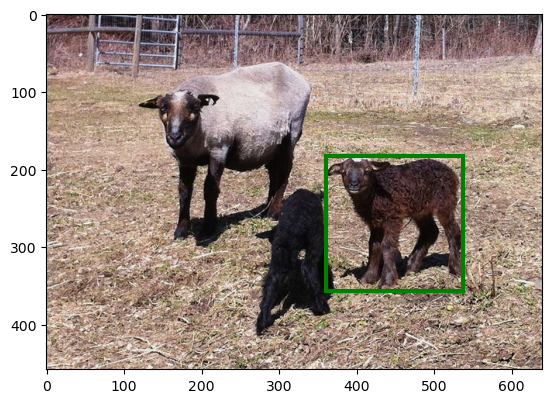

In [31]:
print ('ref_id [%s] (ann_id [%s])' % (ref_id, refer.refToAnn[ref_id]['id']))
# show the segmentation of the referred object
plt.figure()
refer.showRef(ref, seg_box='box')
plt.show()

The following function extracts the sub-image (i.e., within a bounding box) from within the image. 

In [32]:
def get_bounded_subimage(img_id, ann_id, xs=224,ys=224, show=False):
    bbox = refer.Anns[ann_id]['bbox']
    bbox = [int(b) for b in bbox]
    img = refer.Imgs[img_id]
    I = io.imread(os.path.join(refer.IMAGE_DIR, img['file_name']))
    sub = I[bbox[1]:bbox[1]+bbox[3],bbox[0]:bbox[0]+bbox[2]]
    if show:
        plt.figure()
        ax = plt.gca()
        ax.imshow(sub)
        plt.show()
    if len(sub) == 0: return None
    pim = PImage.fromarray(sub)
    pim2 = pim.resize((xs,ys), PImage.Resampling.LANCZOS)    #ANTIALIAS removed
    img = np.array(pim2)
    if len(img.shape) < 3: return None
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    return img

### Example sub-image / object

- the following applies the sheep example to the above function
- notice that it extracts the sub-image so you can pass it through a convnet
- it returns a numpy representation of the image

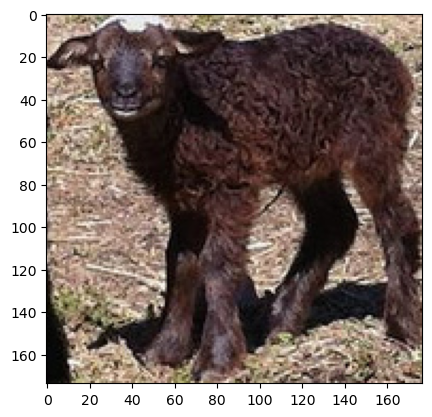

array([[[[201, 175, 155],
         [214, 191, 170],
         [209, 188, 168],
         ...,
         [219, 192, 174],
         [197, 170, 150],
         [184, 157, 135]],

        [[197, 172, 151],
         [214, 192, 171],
         [220, 199, 179],
         ...,
         [202, 175, 156],
         [185, 158, 139],
         [182, 155, 136]],

        [[170, 145, 128],
         [165, 141, 125],
         [193, 169, 154],
         ...,
         [193, 165, 146],
         [206, 179, 159],
         [224, 198, 178]],

        ...,

        [[  4,   4,   5],
         [  7,   7,   8],
         [  8,   8,   7],
         ...,
         [115, 104,  98],
         [117, 104,  90],
         [145, 132, 117]],

        [[  6,   7,   6],
         [  8,   9,   8],
         [  9,   9,   8],
         ...,
         [228, 209, 195],
         [189, 172, 159],
         [144, 129, 116]],

        [[  9,   9,   9],
         [  9,   9,   9],
         [ 11,  11,  10],
         ...,
         [193, 172, 160],
        

In [33]:
get_bounded_subimage(ref['image_id'], ref['ann_id'], show=True)

The following function `compute_posfeats` is a useful function that extracts a handful of extra features, for example, the area that the subimage takes, the x,y coordinates, among other things. Using this function isn't required, but using it will yield better results. 

In [34]:
def compute_posfeats(img_id, ann_id,):
    img = refer.Imgs[img_id]
    bb = refer.Anns[ann_id]['bbox']
    fname = os.path.join(refer.IMAGE_DIR, img['file_name'])
    if not os.path.isfile(fname): return None
    img = io.imread(fname)
    
    if len(img.shape) < 3: return None
    ih, iw, _ = img.shape
    x,y,w,h = bb
    # x1, relative
    x1r = x / iw
    # y1, relative
    y1r = y / ih
    # x2, relative
    x2r = (x+w) / iw
    # y2, relative
    y2r = (y+h) / ih
    # area
    area = (w*h) / (iw*ih)
    # ratio image sides (= orientation)
    ratio = iw / ih
    # distance from center (normalised)
    cx = iw / 2
    cy = ih / 2
    bcx = x + w / 2
    bcy = y + h / 2
    distance = np.sqrt((bcx-cx)**2 + (bcy-cy)**2) / np.sqrt(cx**2+cy**2)
    # done!
    return np.array([x1r,y1r,x2r,y2r,area,ratio,distance]).reshape(1,7)


In [35]:
# example using the sheep example on the compute_posfeats function
compute_posfeats(ref['image_id'], ref['ann_id']).flatten()

array([0.56284375, 0.39737991, 0.83945313, 0.77941048, 0.10567324,
       1.39737991, 0.34295148])

In [36]:
def get_img_features(model, img):
    img = preprocess_input(img)
    yhat = model.predict(img, verbose=False)
    return yhat

In [37]:
import numpy as np
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

model = VGG19(weights='imagenet',include_top=True)
xs,ys=224,224

# Train

In [38]:
from collections import defaultdict as dd
from tqdm.notebook import tqdm

In [39]:
#find negative examples
import random
def get_negative_samples(wac, word, num_negatives=3):
    negs = []
    words = list(wac.keys())
    num_pos = len(wac[word])
    words.remove(word)
    while len(negs) < num_negatives * num_pos:
        num_pos = len(wac)
        #grab random word
        neg_word = random.choice(words)
        #grab random vector for given word
        neg = random.choice(wac[neg_word])
        negs.append(neg)
    return negs

In [40]:
words_as_classifiers = dd(list) # if a key is added to this dictionary, it will initialize its value to a list
neg_words_as_classifiers = dd(list)

# first, get all of the training data
train_ids = refer.getRefIds(split='train')

# for a single train_id, you can get its image_id and the ann_id (i.e., the referring expression)
for ref_id in tqdm(train_ids[:100]):
    ref = refer.Refs[ref_id]
    img_id = ref['image_id']
    ann_id = ref['ann_id']

    #then you'll need to get the bounded subimage by calling the get_bounded_subimage function.
    sub_img = get_bounded_subimage(img_id, ann_id)
    #then, you'll need to pass that image through a convnet like you did for A5
    sub_img = get_img_features(model, sub_img)
    #optionally, you can call the compute_posfeats function to get some additional features
    #concatenate these to the convnet output to form a single vector for this image
    pos_feats = compute_posfeats(img_id, ann_id)

    pos_feature_vector = np.concatenate((sub_img, pos_feats), axis=1)
    #add this feature vector to a list of positive examples for each word in the referring expression
    #you may need to flatten() the feature vector
    for sent in ref['sentences']:
        for word in sent['tokens']:
            words_as_classifiers[word].append(pos_feature_vector.flatten())
# once you have all of the positive examples for all of the words, you'll need to find negative examples for each word
# the number of negative examples should be a function of how many positive examples there are
for word in words_as_classifiers:
    neg_words_as_classifiers[word] = get_negative_samples(words_as_classifiers, word)
# finally, train a binary classifier for each word

  0%|          | 0/100 [00:00<?, ?it/s]

In [58]:
# start with a scikit-learn classifier
from sklearn.linear_model import LogisticRegression
import numpy as np

classifiers = {}

# train binary classifier for each word
for word in tqdm(words_as_classifiers):
    pos_samples = words_as_classifiers[word]
    neg_samples = neg_words_as_classifiers[word]

    #set X and y train
    X_train = pos_samples + neg_samples
    y_train = [1] * len(pos_samples) + [0] * len(neg_samples)

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)

    classifiers[word] = classifier

  0%|          | 0/228 [00:00<?, ?it/s]

# Validate

In [59]:
eval_ids = refer.getRefIds(split='val')

In [65]:
for ref_id in tqdm(eval_ids[:5]):
    obj_feature_vectors = {}
    
    # get all of the objects as feature vectors for an image using your convnet
    ref = refer.Refs[ref_id]
    img_id = ref['image_id']
    ref_id = ref['ann_id']    # get the "gold"
    img = refer.Imgs[img_id]
    objs = refer.getAnnIds(img_id)

    # get all of the objects as feature vectors for an image using your convnet
    for obj in objs:
        sub_img = get_bounded_subimage(img_id, obj)
        sub_img = get_img_features(model, sub_img)
        pos_feats = compute_posfeats(img_id, obj)
        feature_vector = np.concatenate((sub_img, pos_feats), axis=1)
        obj_feature_vectors[obj] = feature_vector
    # for each object
    obj_probabilities = {obj: 1.0 for obj in objs}
    for obj in obj_feature_vectors.values():
        # for each referring expression / sentence
        obj_prob = 1
        for sent in ref['sentences']:
            # apply all of the feature vectors to trained classifiers for each word in the sentence
            for word in sent['tokens']:
                if word in classifiers:
                    # multiply the classifier probabilities together for each word
                    obj_prob *= classifiers[word].predict_proba(obj)
        #obj_probabilities[obj] = obj_prob

  0%|          | 0/5 [00:00<?, ?it/s]

In [44]:
# step through the eval ids
# get all of the objects as feature vectors for an image using your convnet
# for each object,
# for each referring expression / sentence
# apply all of the feature vectors to your trained classifiers for each word in the sentence
# multiply the classifier probabilities together for each word
# e.g., for the last sentence above: Pblue(object1) * Pshirt(object1)
# find the object with the highest resulting multiplied probability, compare to gold, compute accuracy

# Evaluate

- perform evaluation on the final test set **after** you're done developing and improving your model
- (you can run the cell below, then run the evaluation code you wrote as this overrides the `eval_ids` variable with the held out test set


In [56]:
eval_ids = refer.getRefIds(split='test')

# Questions

- (answer the following below as a markdown cell)
- How well does your model perform on the test set (using the accuracy metric)?
- Is that a good score? How do you know?
- What assumptions does your model make? Hint: what would happen if the sentences/referring expressions had a different word order? Would it make a difference?
- What could you do to improve the model?